# Transform data to onavg space

In this Jupyter Notebook we demonstrate how to transform data between other surface template spaces and the `onavg` template space using the `neuroboros` package.

In [1]:
import os
import numpy as np
import neuroboros as nb
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, zscore

In the examples below, we will use data in the fsaverage template space with ico64 resolution (`fsavg-ico64`, also known as fsaverage6) and transform it to the `onavg` template space with ico32 resolution (`onavg-ico32`). This process is also called resampling.

The code can be easily modified (by changing the `source` and `target` parameters in `nb.mapping`) to transform data from and to other spaces.

## Inter-subject correlation

In the first example, the data to be transformed is inter-subject correlation (ISC) of response time series to the movie _Forrest Gump_ (3T fMRI data of the [StudyForrest](https://www.studyforrest.org/) dataset).

We compute the correlation between the test subject's time series and the average of other subjects' time series for each vertex, to obtain a correlation map per test subject (leave–one-subject-out).
The correlation maps are then averaged across subjects, yielding a single average correlation map.

In [2]:
for space in ['fsavg-ico64', 'onavg-ico32']:
    cache_fn = f'isc_{space}.pkl'
    if not os.path.exists(cache_fn):
        dset = nb.Forrest()
        sids = dset.subjects
        isc_fsavg = []
        for lr in 'lr':
            dms = np.stack([
                dset.get_data(sid, 'forrest', 1, lr, space)
                for sid in sids])
            isc = []
            for i, dm in enumerate(dms):
                pred = np.delete(dms, i, axis=0).mean(axis=0)
                r = np.mean(zscore(dm, axis=0) * zscore(pred, axis=0), axis=0)
                isc.append(r)
            isc_fsavg.append(np.nanmean(isc, axis=0))
        nb.save(cache_fn, isc_fsavg)
isc_fsavg = nb.load(f'isc_fsavg-ico64.pkl')

`isc_fsavg` is a list of two NumPy arrays, which are the ISCs for the left and right hemispheres, respectively.

In [3]:
print([_.shape for _ in isc_fsavg])

[(38073,), (38040,)]


In [4]:
xfms1 = [
    nb.mapping(lr, 'fsavg-ico64', 'onavg-ico32', mask=True, keep_sum=False)
    for lr in 'lr']

`xfms1` is a list of two sparse matrices, which are the transformations for the left and right hemispheres, respectively.

In [5]:
print(len(xfms1))
for xfm in xfms1:
    print(type(xfm), xfm.shape, xfm.data.shape)

2
<class 'scipy.sparse._csc.csc_matrix'> (38073, 9675) (154778,)
<class 'scipy.sparse._csc.csc_matrix'> (38040, 9666) (154354,)


By applying `xfms1` to `isc_fsavg`, we obtain the transformed data, which are in the `onavg-ico32` space.

In [6]:
isc_t1 = [isc @ xfm for isc, xfm in zip(isc_fsavg, xfms1)]

In [7]:
print([_.shape for _ in isc_t1])

[(9675,), (9666,)]


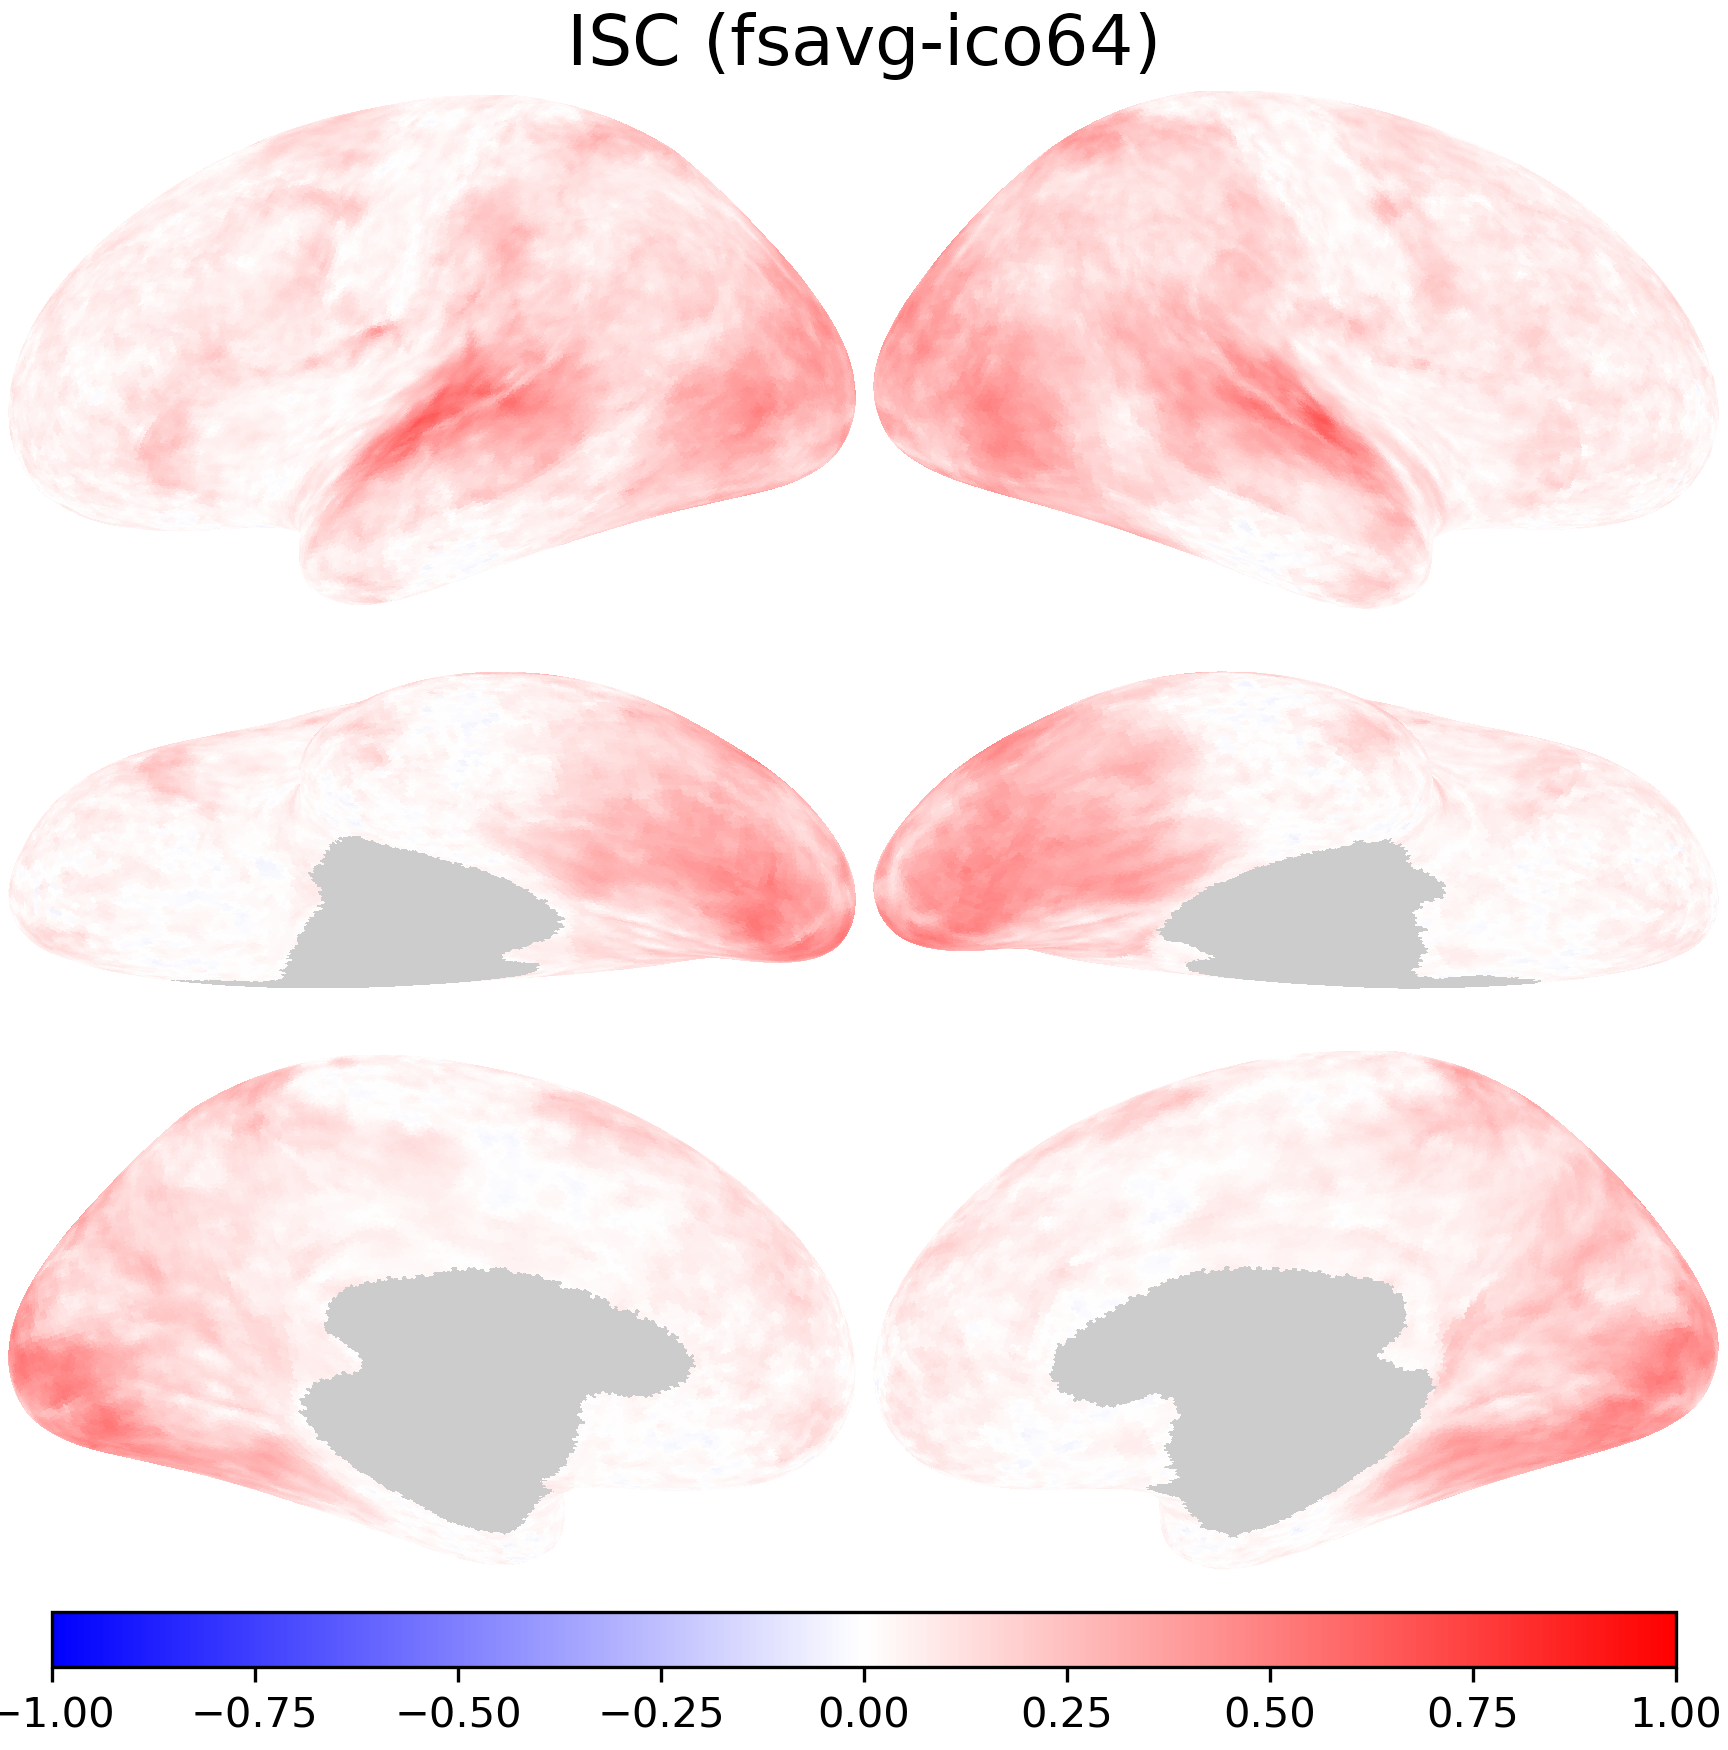

In [8]:
kwargs = dict(vmax=1, vmin=-1, width=400, cmap='bwr')
nb.plot(isc_fsavg, title='ISC (fsavg-ico64)',
        fn='figures/space_travel_ISC_fsavg.png', **kwargs)

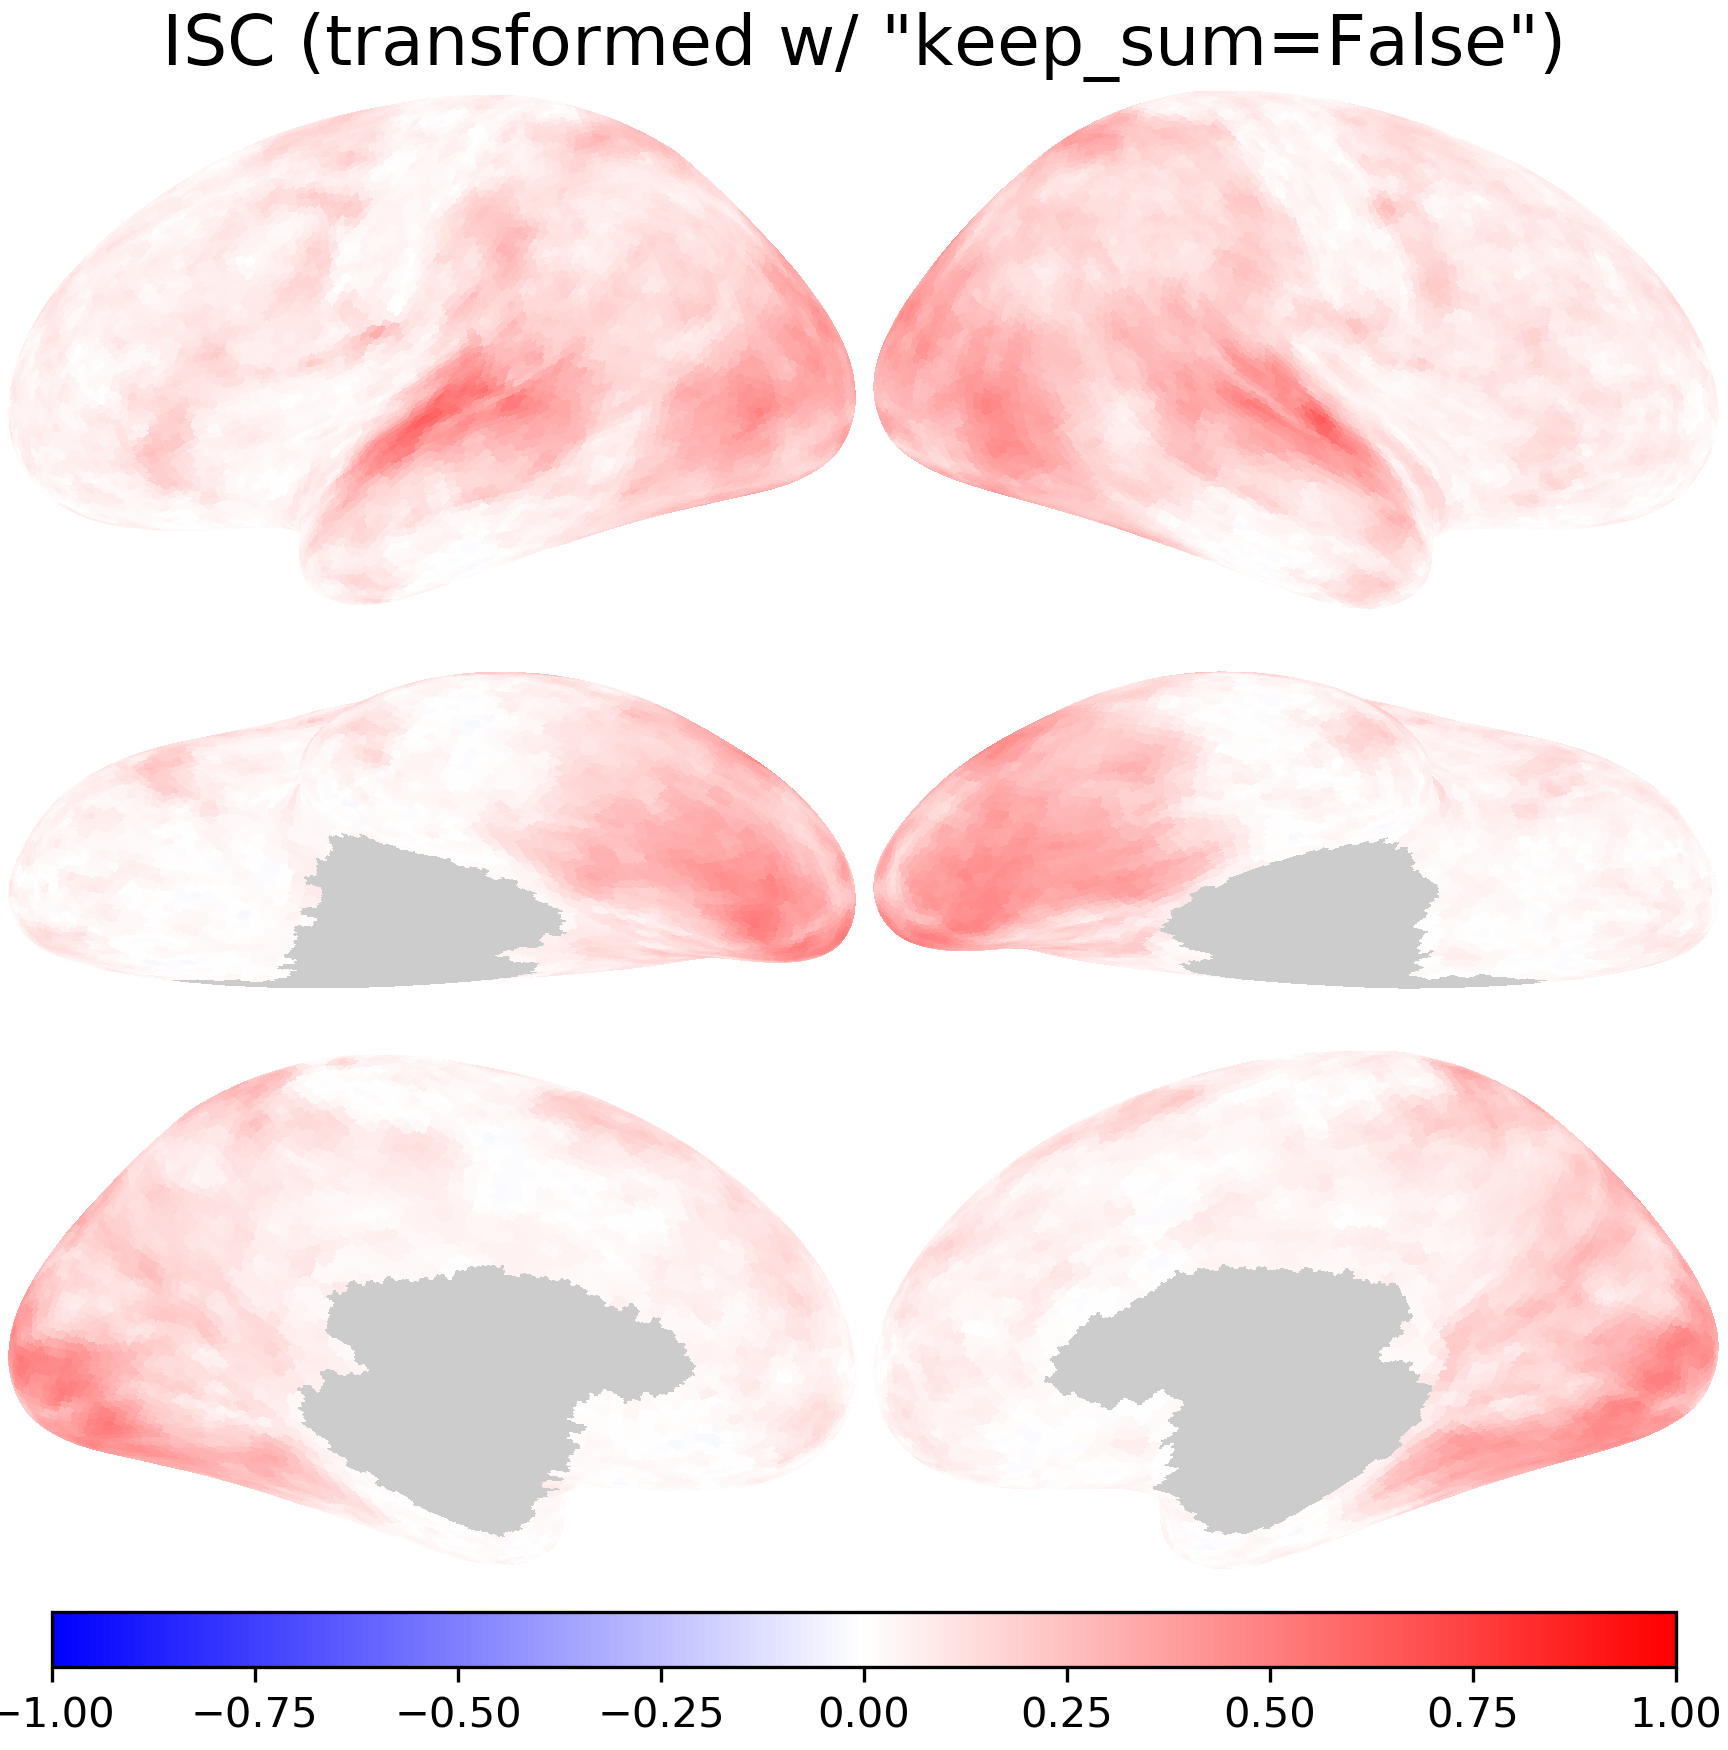

In [9]:
nb.plot(isc_t1, title='ISC (transformed w/ "keep_sum=False")',
        fn='figures/space_travel_ISC_t1.png', **kwargs)

::::{grid}

:::{grid-item-card}
![](figures/space_travel_ISC_fsavg.png)
:::

:::{grid-item-card}
![](figures/space_travel_ISC_t1.png)
:::

::::

The transformed ISCs are very close to those computed directly using data in the `onavg-ico32` space.

In [10]:
isc_onavg = nb.load(f'isc_onavg-ico32.pkl')
print(pearsonr(np.concatenate(isc_onavg), np.concatenate(isc_t1)))

PearsonRResult(statistic=0.9987059747698581, pvalue=0.0)


## Vertex area

Mathematically, transforming data between different spaces is a matrix multiplication:

$$Y = X T$$

If the input data has $n$ vertices and the output data has $m$ vertices, $X$ is a row vector of $1 \times n$ elements, $Y$ is a row vector of $1 \times m$ elements, and $T$ is an $n \times m$ matrix.

In other words, each element in $Y$ is a weighted sum of the elements in $X$

$$Y_j = \sum_{i=1}^{n}X_i T_{i,j}$$

By default `nb.mapping` will normalize the columns of $T$, so that the sum of each column equals one. That is,

$$\sum_{i=1}^{n}T_{i,j} = 1, \text{for } j = 1 \ldots m$$

With this, the sum of the weights for the weighted sum equals one, and the scale of **each element** in $Y$ is comparable to the scale of **each element** in $X$.
This is appropriate for resampling statistics, such as the ISC example above.

When resample some quantitative measures, such as cortical area or volume, it is more appropriate to keep the total quantity constant, that is, making the **sum of all elements** in $Y$ the same as the **sum of all elements** in $X$.
To achieve this goal, the rows of $T$ are normalized to have unit sum instead of the columns.

This can be done by setting the parameter `keep_sum=True` when using `nb.mapping`.

In [11]:
area_fsavg = [
    nb.morphometry('area', lr, space='fsavg-ico64')[nb.mask(lr, 'fsavg-ico64')]
    for lr in 'lr']

In [12]:
xfms2 = [nb.mapping(lr, 'fsavg-ico64', 'onavg-ico32', mask=True, keep_sum=True)
         for lr in 'lr']
area_t2 = [a @ xfm for a, xfm in zip(area_fsavg, xfms2)]

After resampling with `keep_sum=True`, the average vertex area is approximately 4x as large (due to the change in data resolution), whereas the sum of vertex area is approximately the same.

In [13]:
for area in [area_fsavg, area_t2]:
    area = np.concatenate(area)
    print(f'{area.shape[0]} vertices, mean = {area.mean():.2f} mm^2, '
          f'sum = {area.sum():.2e} mm^2')

76113 vertices, mean = 2.37 mm^2, sum = 1.80e+05 mm^2
19341 vertices, mean = 9.31 mm^2, sum = 1.80e+05 mm^2


## Comparing resampling methods for ISC

When resampling statistics, it is necessary to keep the default `keep_sum=False`.
Otherwise, the scale of individual values in resampled data can be very different from that of the original data.

For example, when resampling inter-subject correlation, with `keep_sum=True` the resampled values can be larger than one, which does not make sense, as correlation coefficients should be no larger than one.

In [14]:
isc_t2 = [isc @ xfm for isc, xfm in zip(isc_fsavg, xfms2)]
isc_data = [isc_fsavg, isc_t1, isc_t2, isc_onavg]
labels = ['fsavg-ico64',
          'mapped to onavg-ico32, "keep_sum=False"',
          'mapped to onavg-ico32, "keep_sum=True"',
          'onavg-ico32']

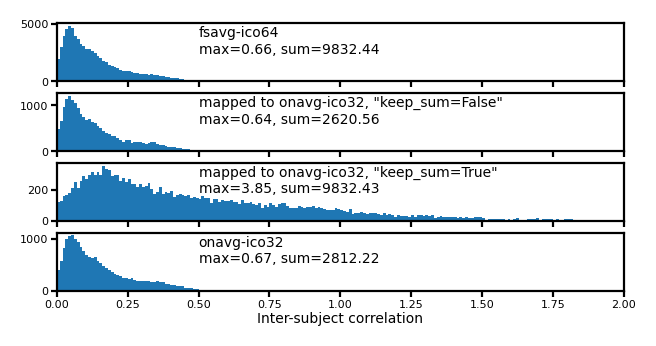

In [15]:
fig, axs = plt.subplots(4, 1, figsize=[_/2.54 for _ in [8, 4]],
                        sharex=True, dpi=200)
for i, ax in enumerate(axs):
    d, label = np.concatenate(isc_data[i]), labels[i]
    bins = np.linspace(0, 2, 201)
    ax.hist(d, bins)
    ax.set_xlim([bins[0], bins[-1]])
    ax.annotate(f'{label}\nmax={d.max():.2f}, sum={d.sum():.2f}', (0.25, 0.95),
                xycoords='axes fraction', size=5, va='top', ha='left')
    ax.tick_params(size=2, pad=1, labelsize=4)
ax.set_xlabel('Inter-subject correlation', size=5, labelpad=1)
fig.subplots_adjust(left=0.08, right=0.98, top=0.97, bottom=0.12)
plt.savefig('figures/space_travel_hist_ISC.png', dpi=300, transparent=True)
plt.show()

![](figures/space_travel_hist_ISC.png)

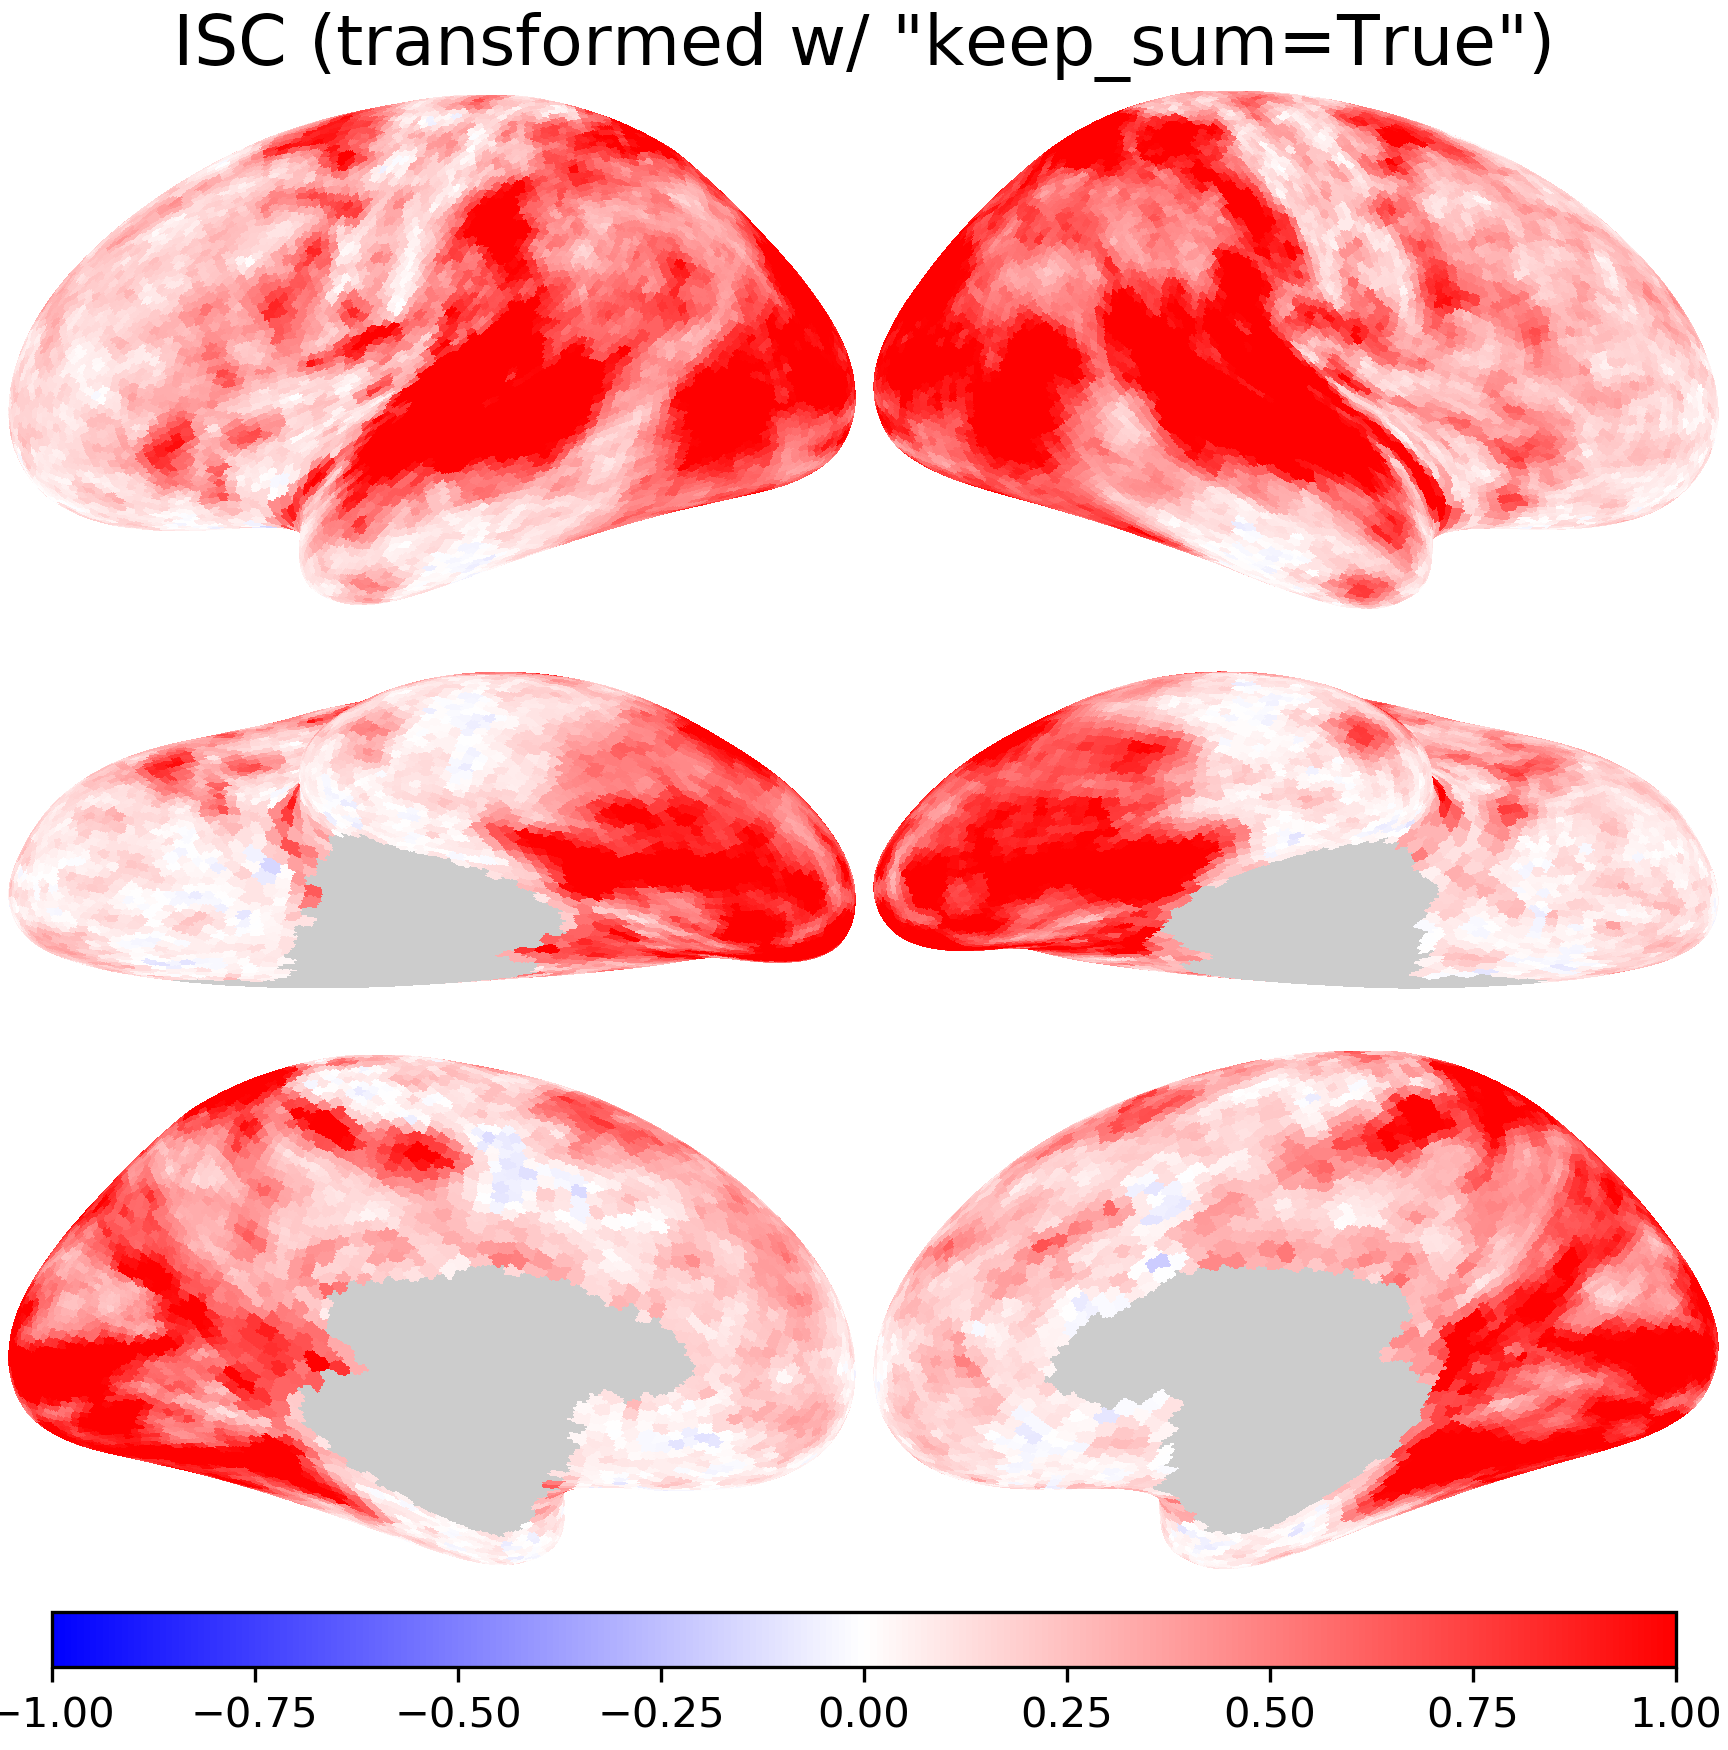

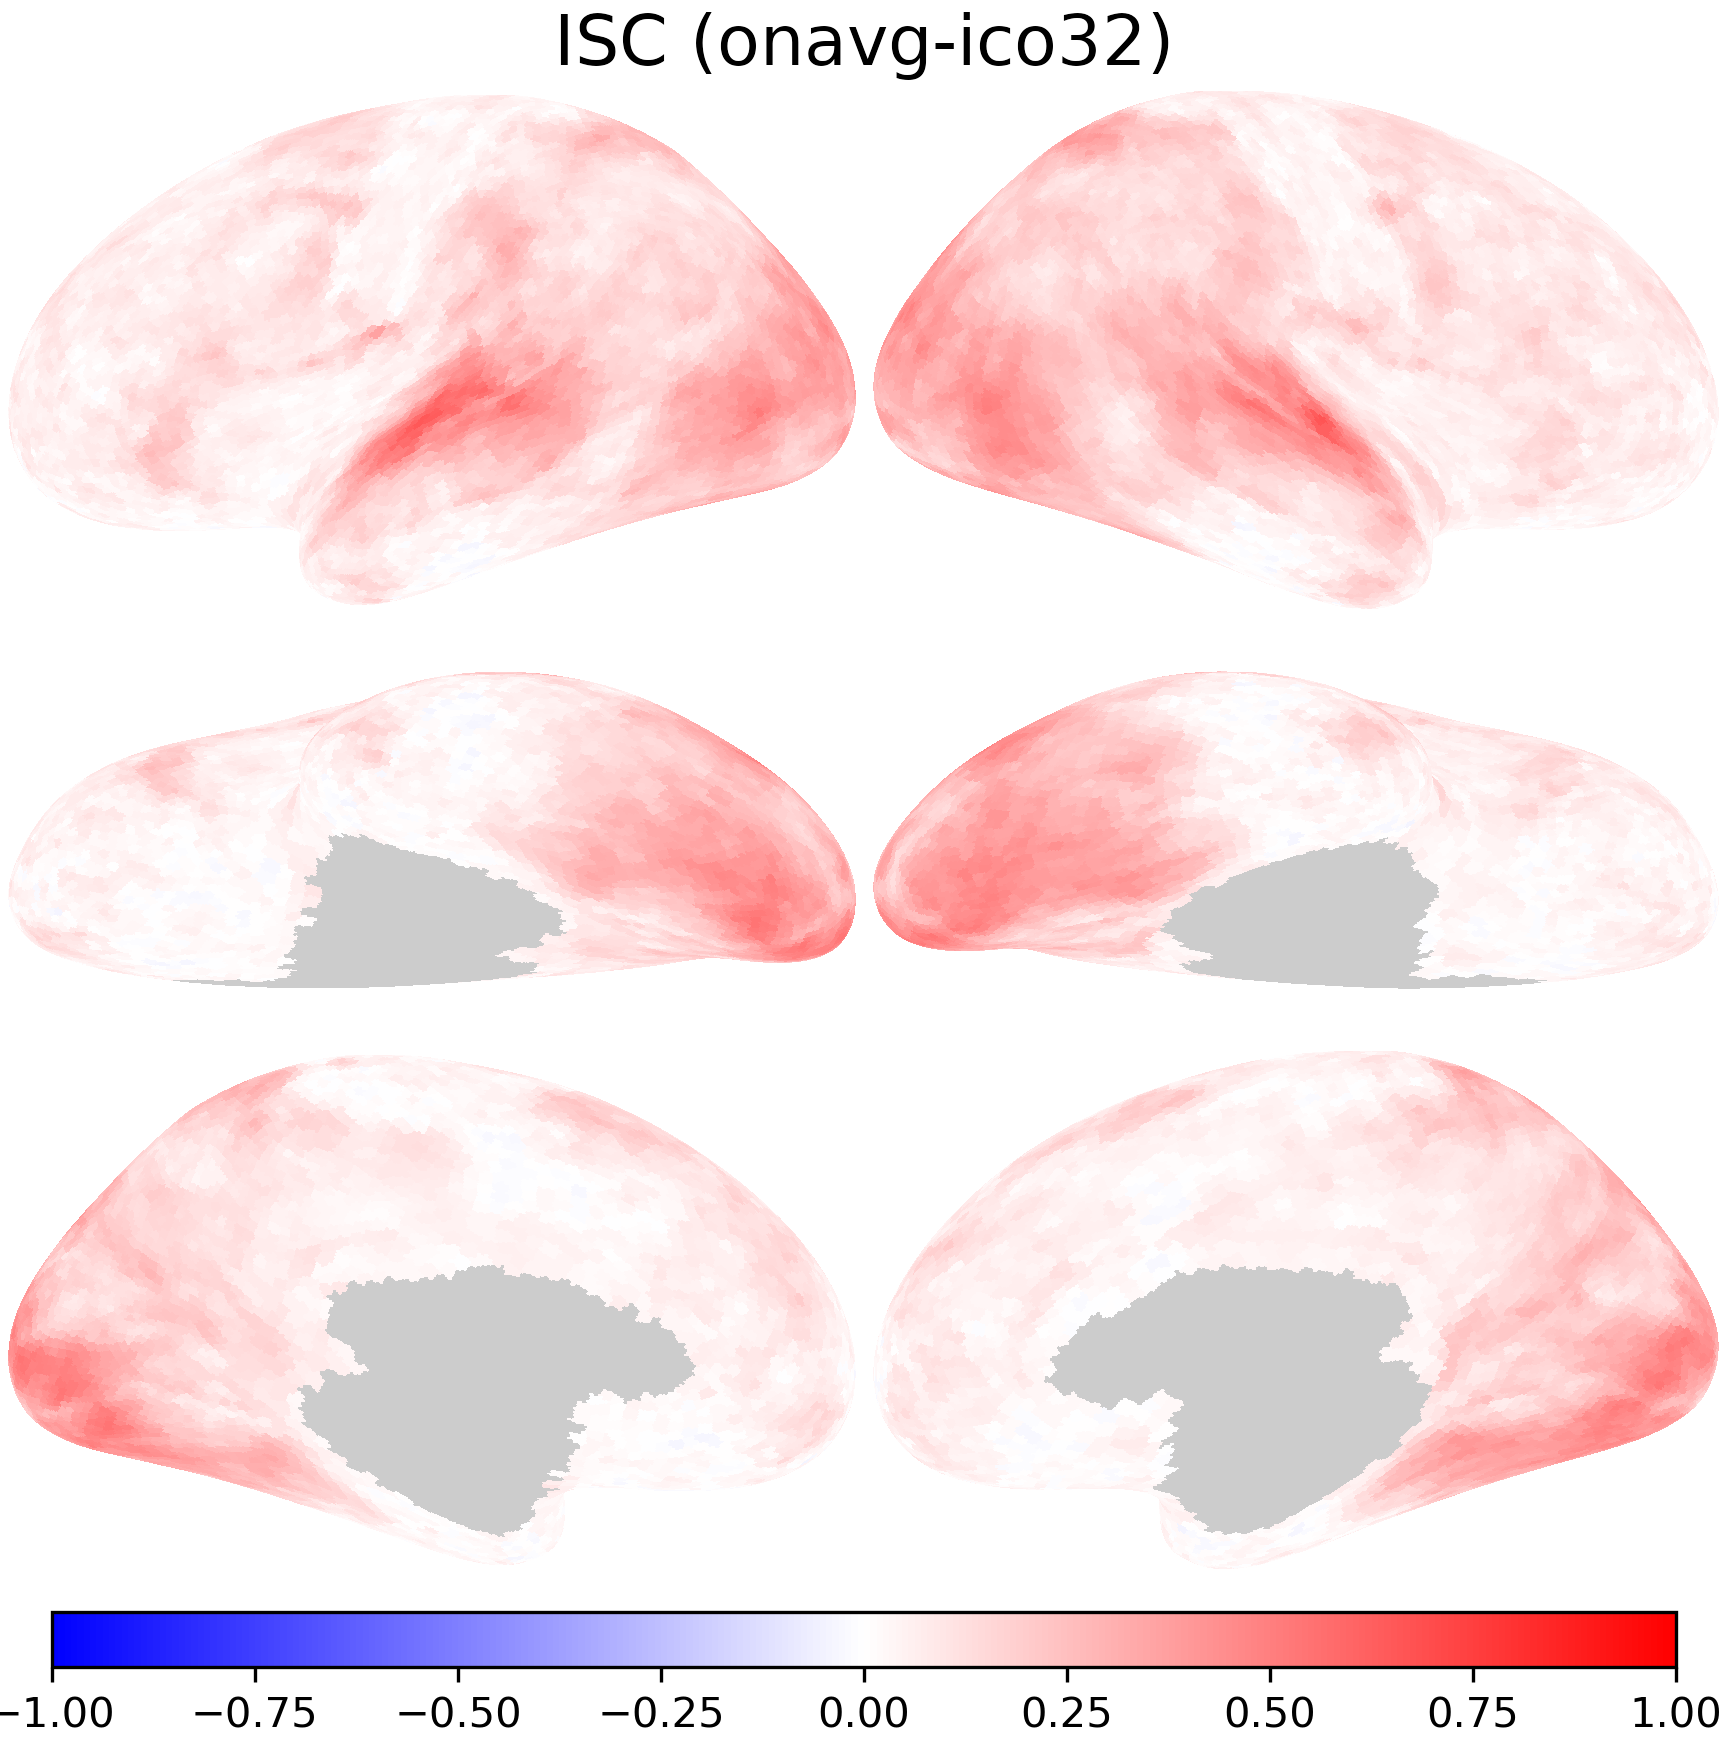

In [16]:
nb.plot(isc_t2, title='ISC (transformed w/ "keep_sum=True")',
        fn='figures/space_travel_ISC_t2.png', **kwargs)
nb.plot(isc_onavg, title='ISC (onavg-ico32)',
        fn='figures/space_travel_ISC_onavg.png', **kwargs)

:::::{div} full-width

::::{grid}

:::{grid-item-card}
![](figures/space_travel_ISC_fsavg.png)
:::

:::{grid-item-card}
![](figures/space_travel_ISC_t1.png)
:::

:::{grid-item-card}
![](figures/space_travel_ISC_t2.png)
:::

:::{grid-item-card}
![](figures/space_travel_ISC_onavg.png)
:::

::::

:::::

## Comparing resampling methods for vertex area

When resampling quantitative measures, it is necessary to use `keep_sum=True`.
Otherwise, the total amount of the quantity can be very different from that of the original data.

For example, when resampling vertex area, with `keep_sum=False` the sum of vertex area is much smaller than that of the original data.

In [17]:
area_onavg = [
    nb.morphometry('area', lr, space='onavg-ico32')[nb.mask(lr, 'onavg-ico32')]
    for lr in 'lr']
area_t1 = [a @ xfm for a, xfm in zip(area_fsavg, xfms1)]
area_data = [area_fsavg, area_t1, area_t2, area_onavg]

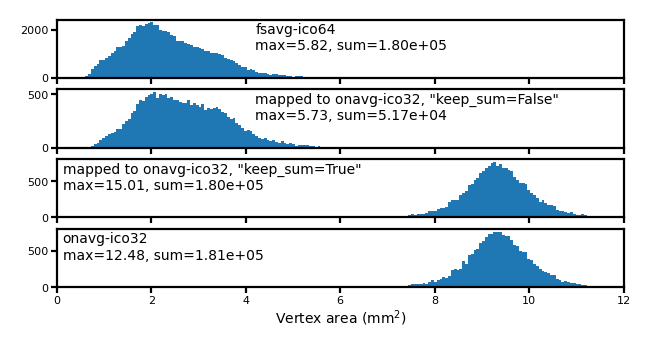

In [18]:
fig, axs = plt.subplots(4, 1, figsize=[_/2.54 for _ in [8, 4]],
                        sharex=True, dpi=200)
for i, ax in enumerate(axs):
    d, label = np.concatenate(area_data[i]), labels[i]
    bins = np.linspace(0, 12, 201)
    ax.hist(d, bins)
    ax.set_xlim([bins[0], bins[-1]])
    ax.annotate(f'{label}\nmax={d.max():.2f}, sum={d.sum():.2e}',
                ([0.35, 0.01][i>1], 0.95),
                xycoords='axes fraction', size=5, va='top', ha='left')
    ax.tick_params(size=2, pad=1, labelsize=4)
ax.set_xlabel('Vertex area (mm$^2$)', size=5, labelpad=1)
fig.subplots_adjust(left=0.08, right=0.98, top=0.97, bottom=0.12)
plt.savefig('figures/space_travel_hist_area.png', dpi=300, transparent=True)
plt.show()

![](figures/space_travel_hist_area.png)

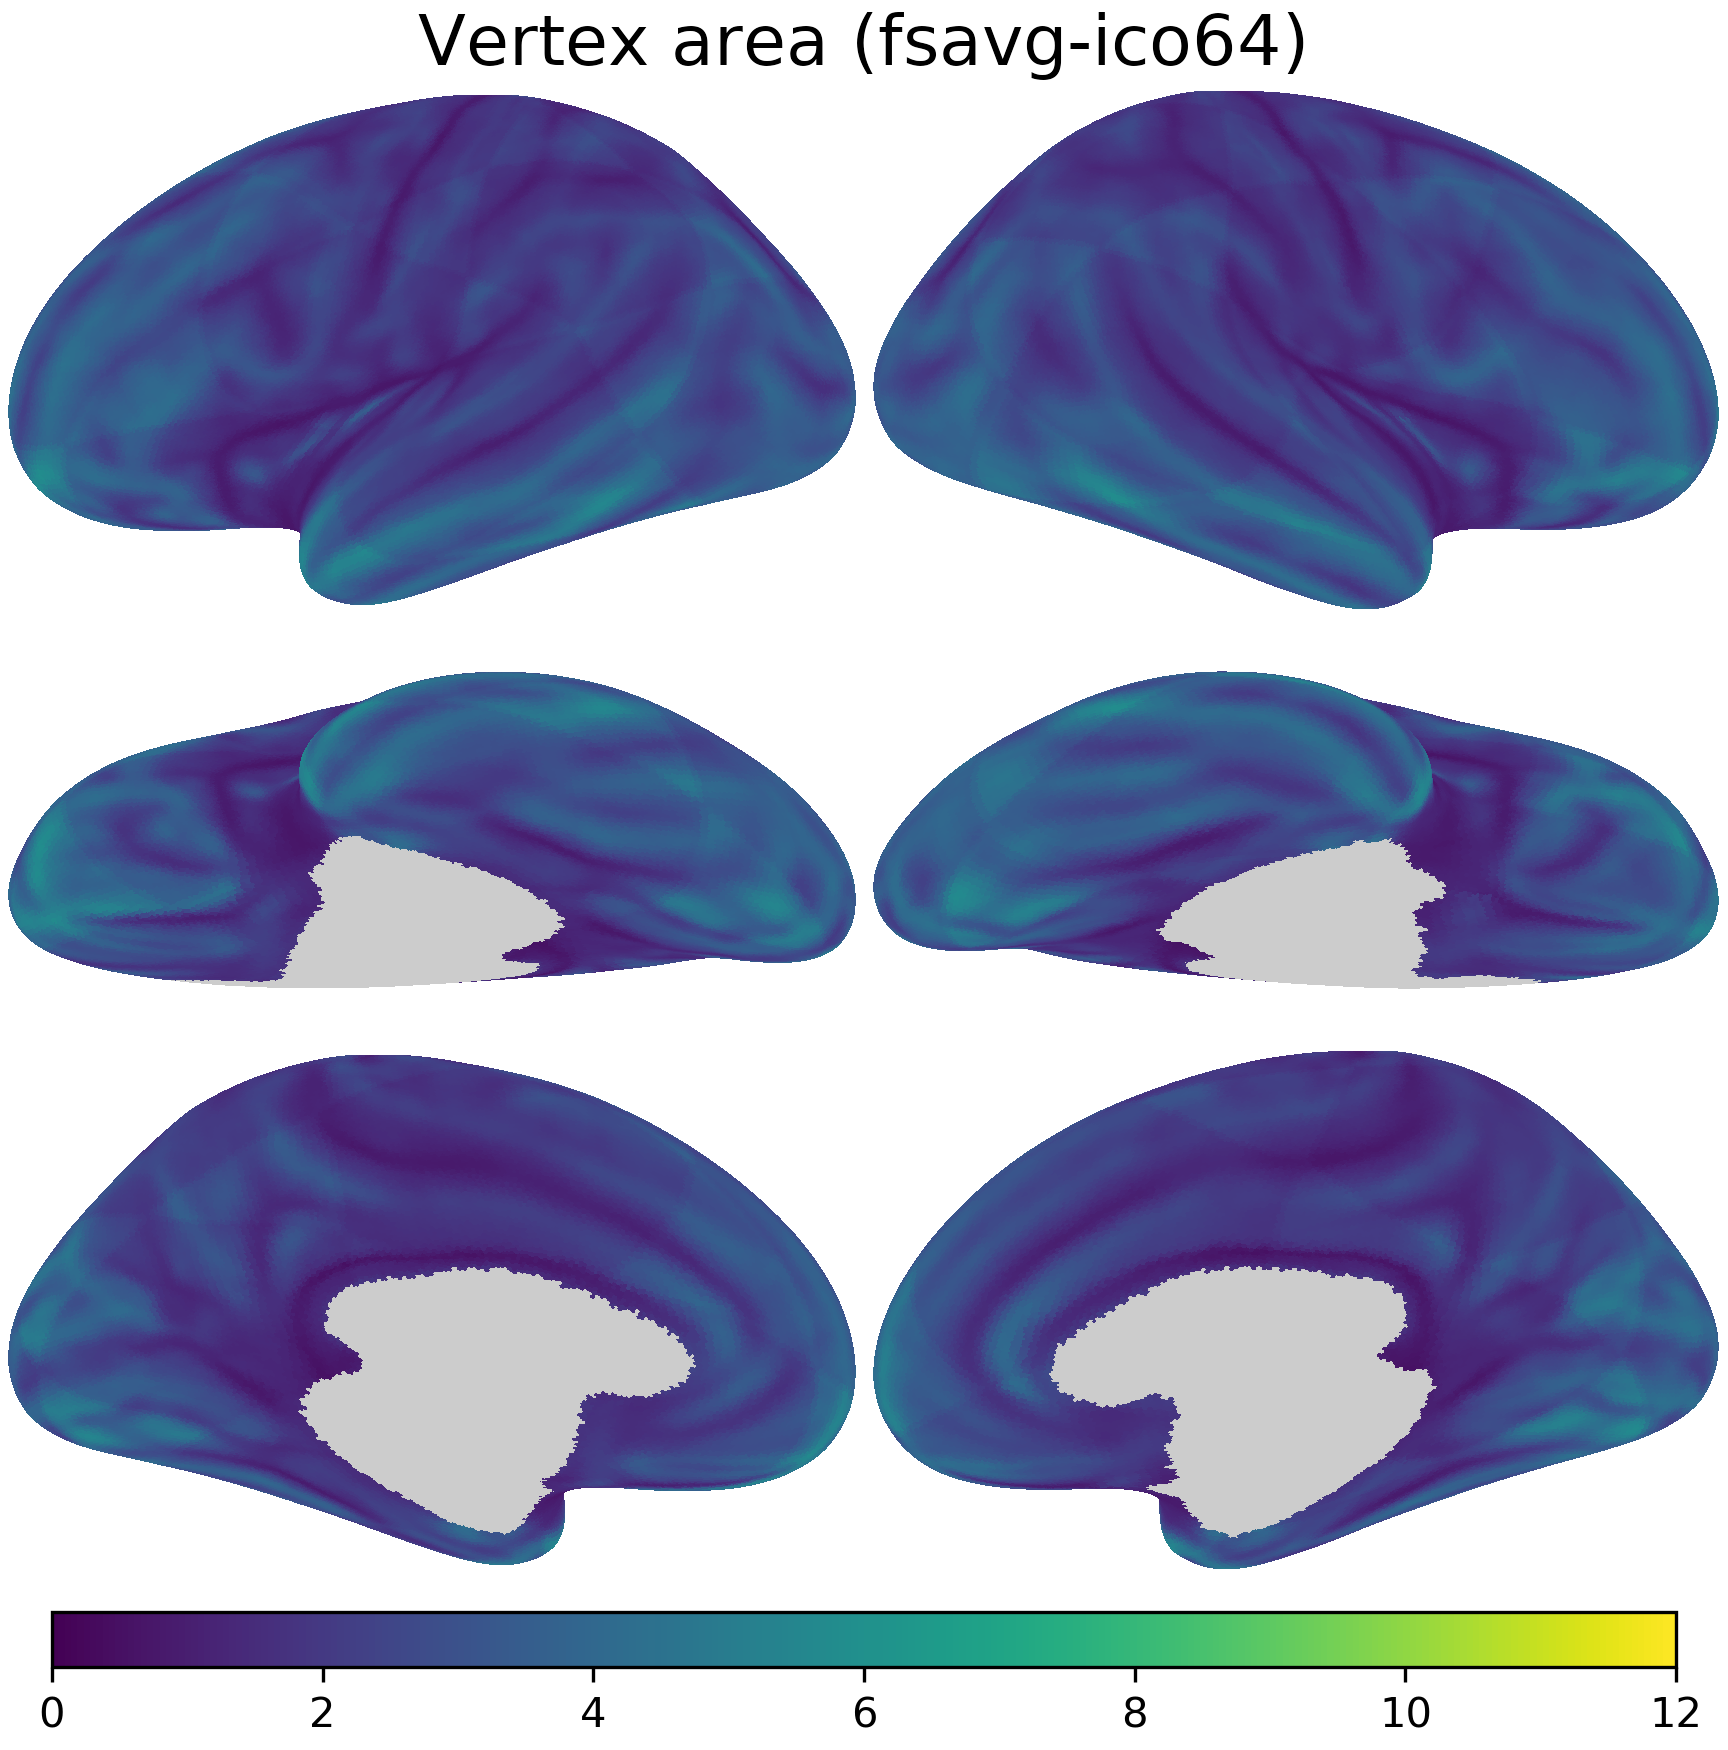

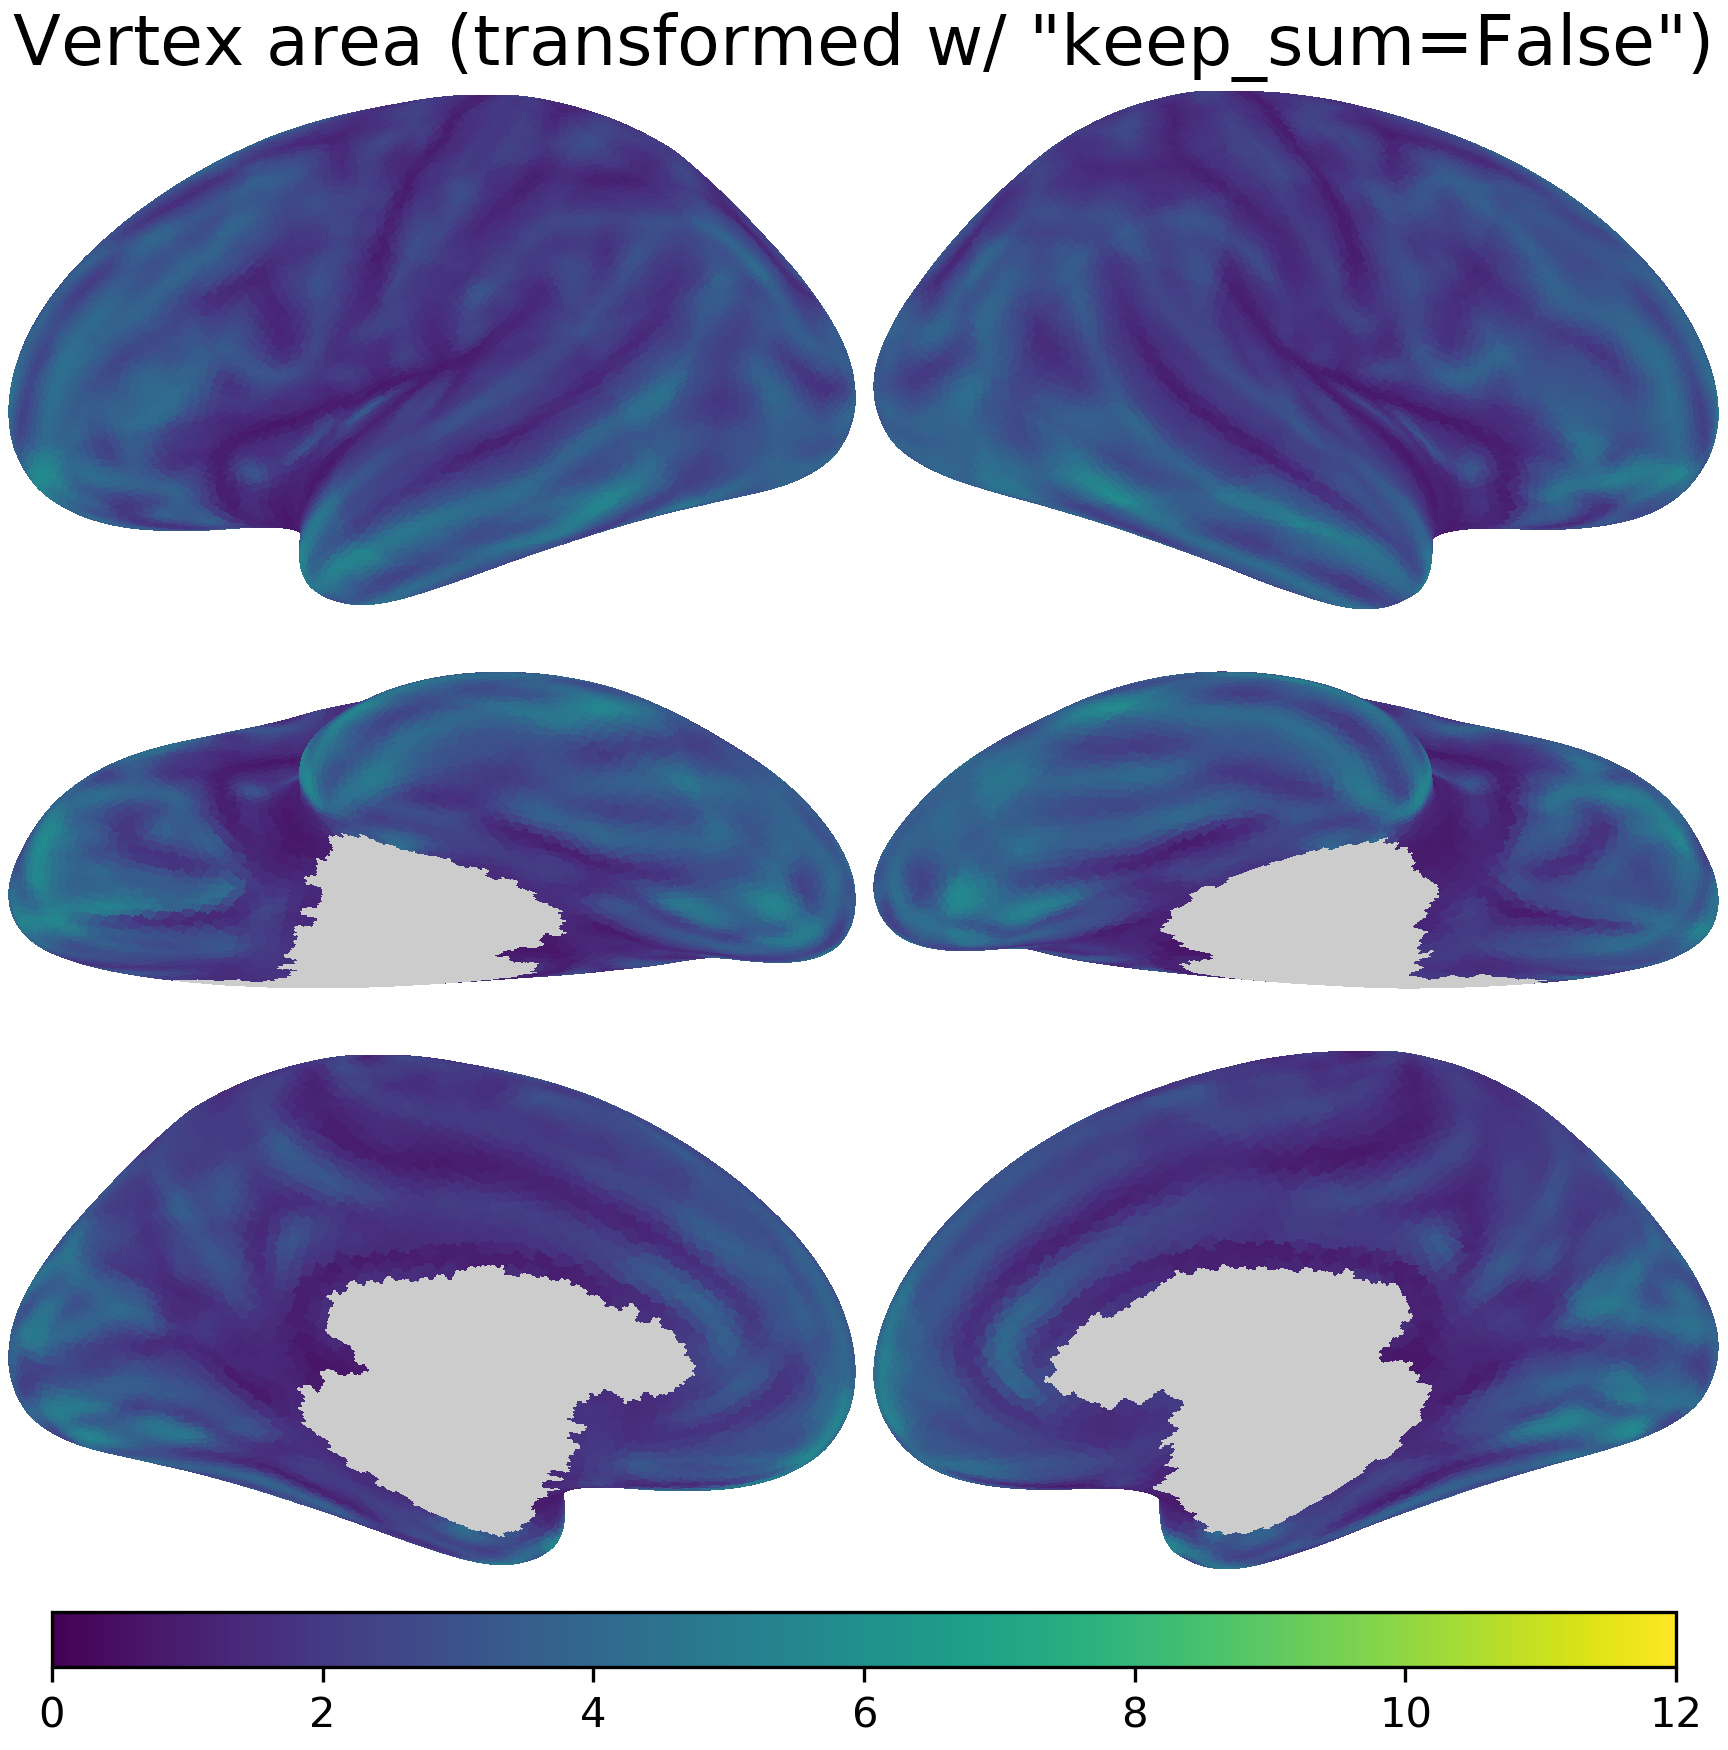

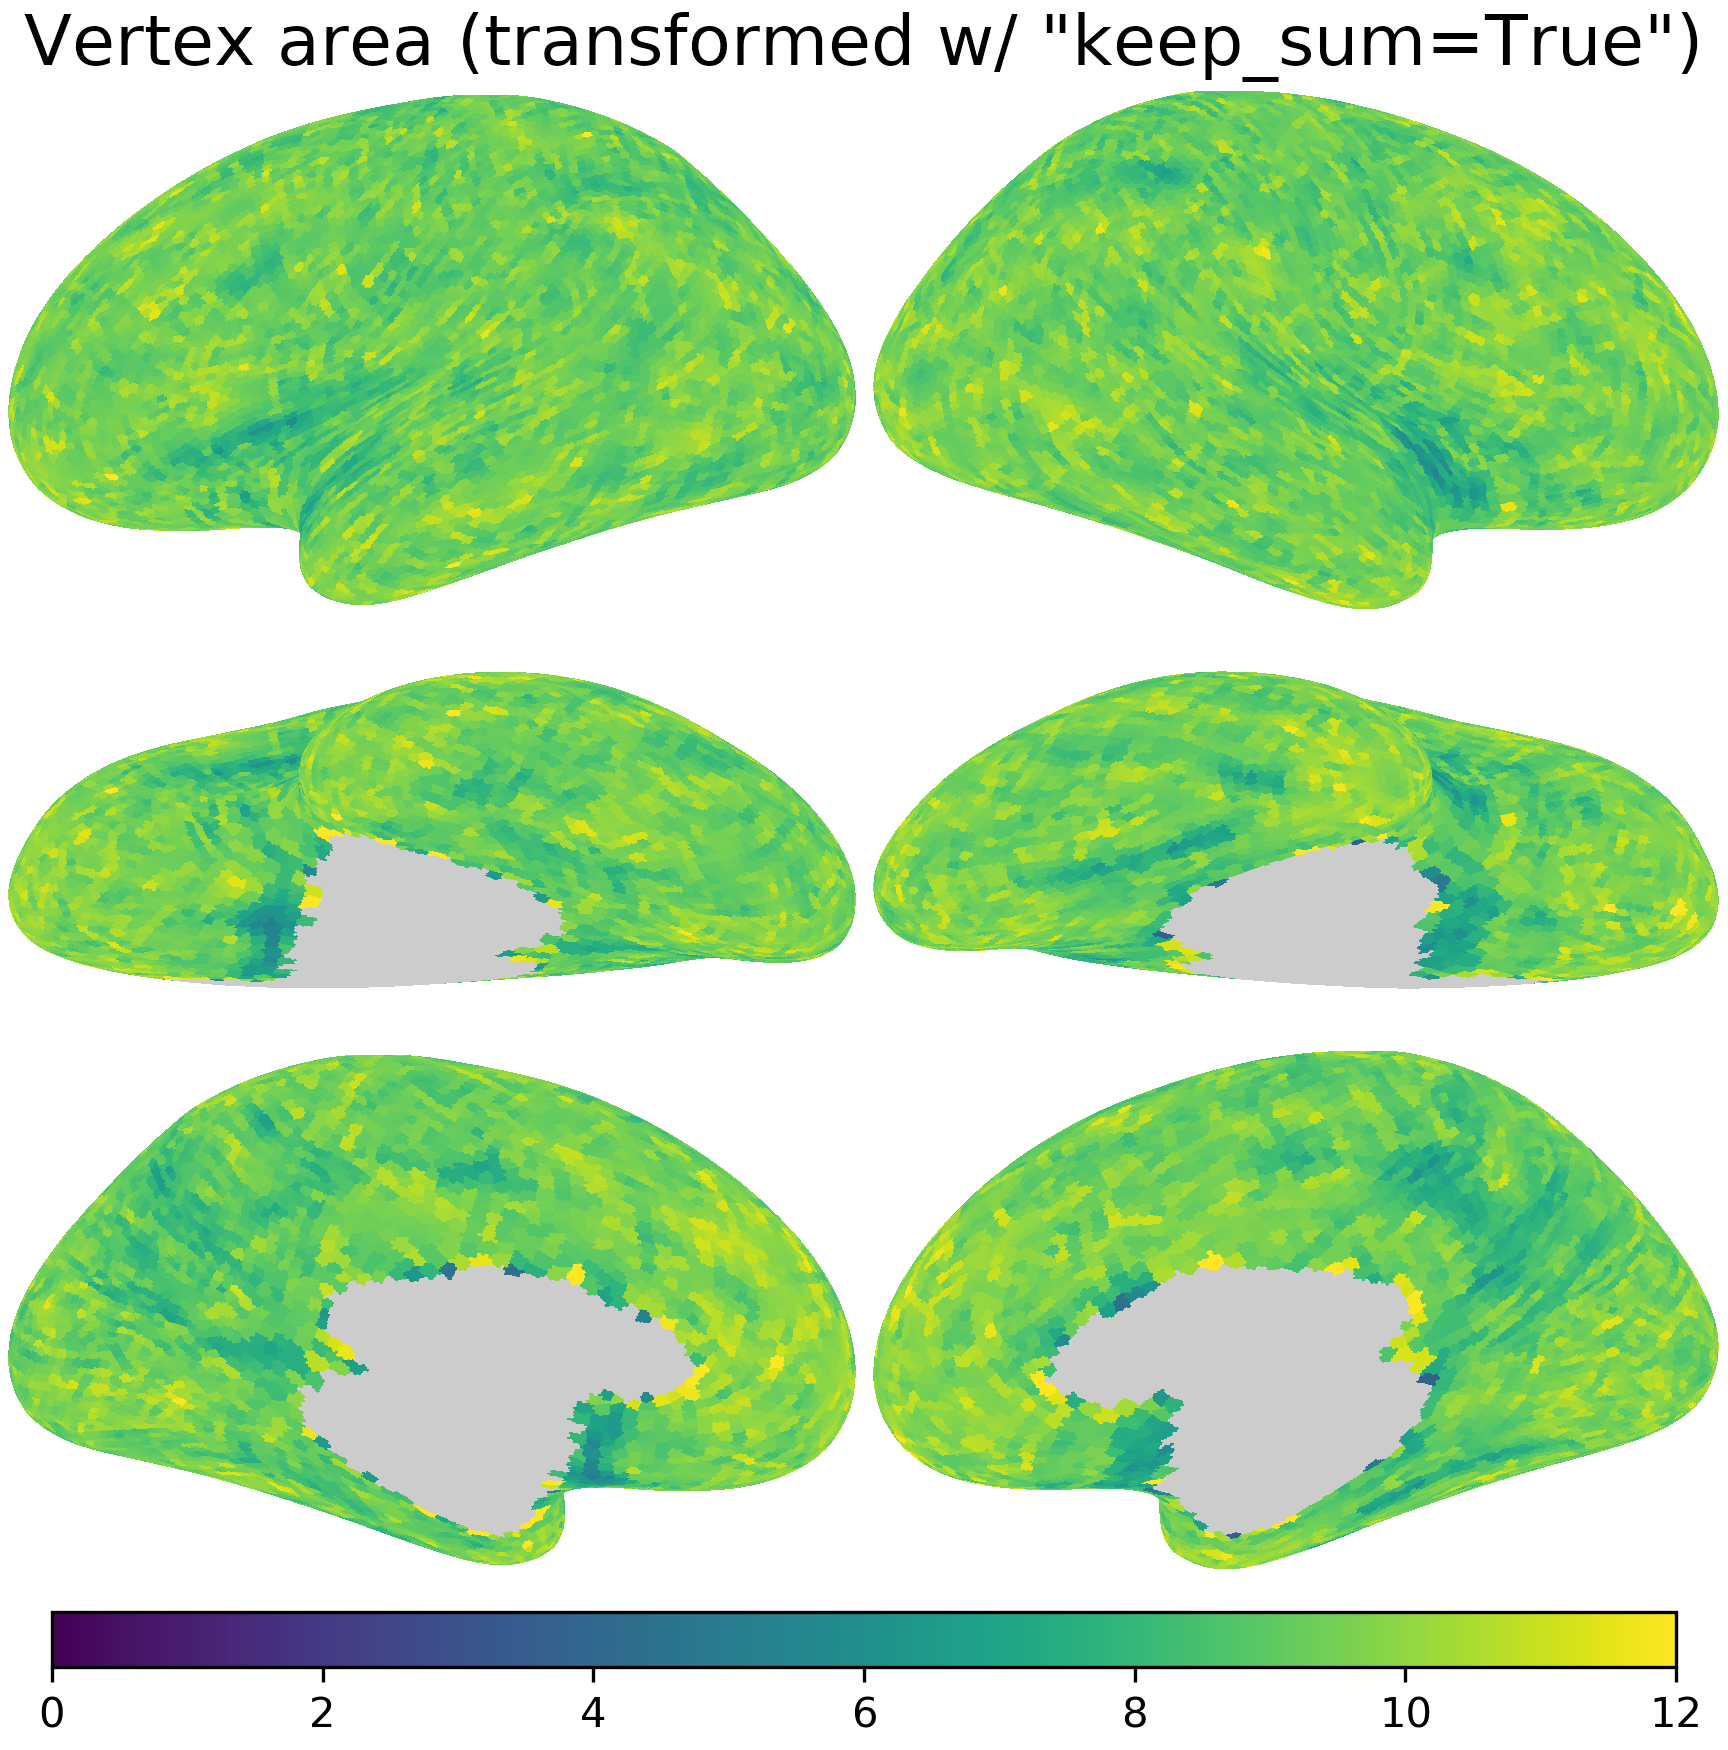

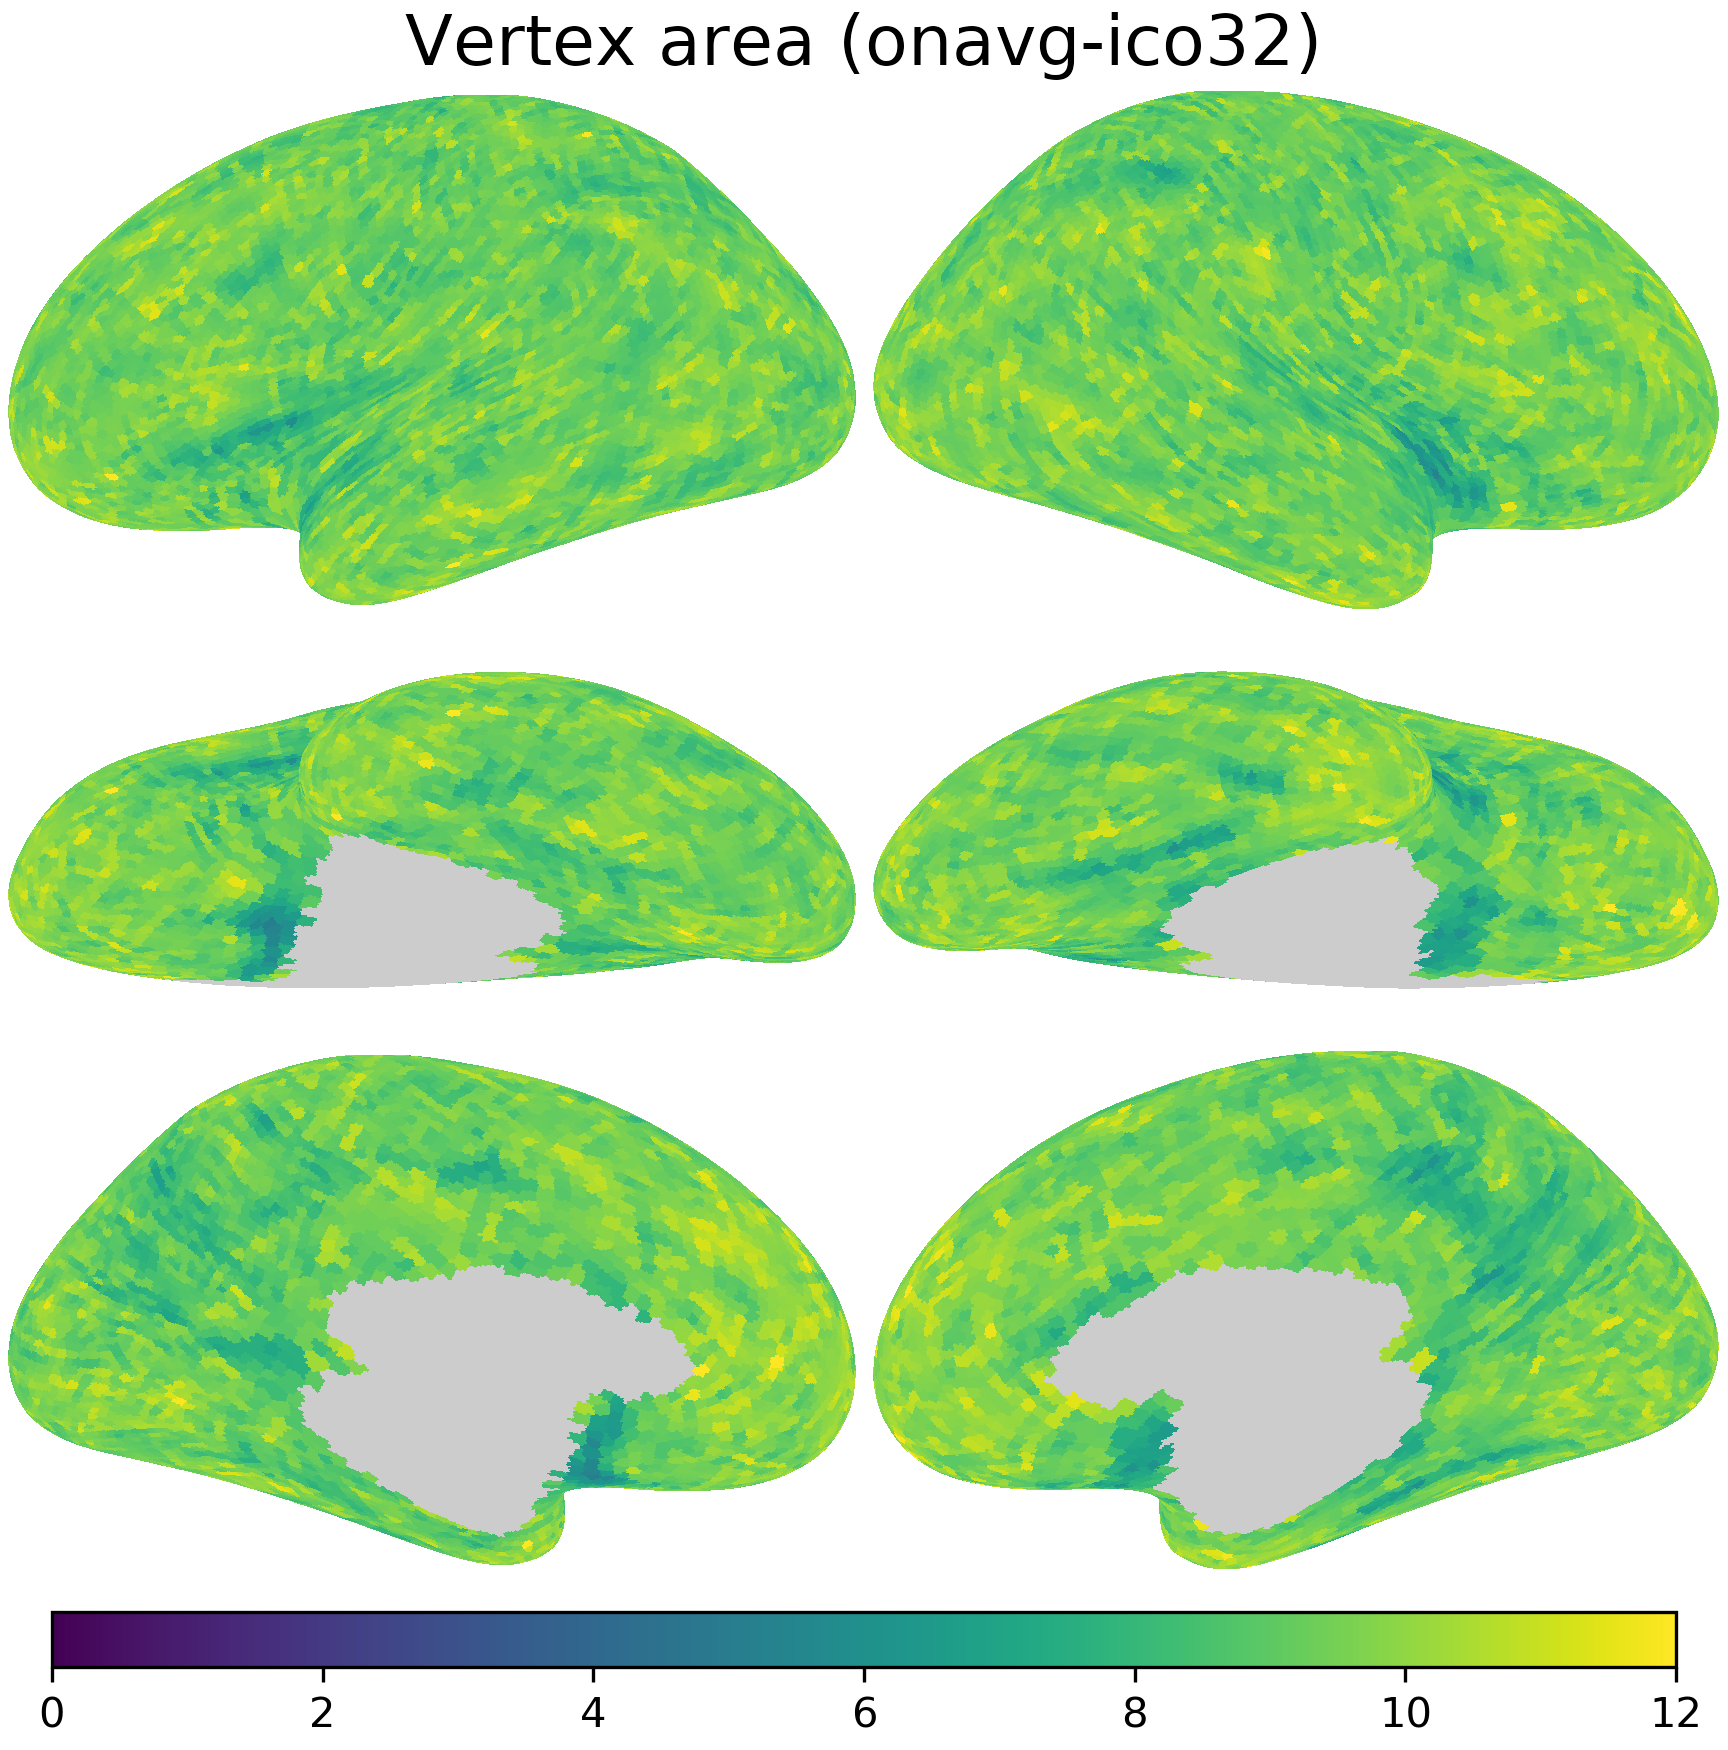

In [19]:
kwargs2 = {'vmin': 0, 'vmax': 12, 'cmap': 'viridis', 'width': 400}
nb.plot(area_fsavg, title='Vertex area (fsavg-ico64)',
        fn='figures/space_travel_area_fsavg.png', **kwargs2)
nb.plot(area_t1, title='Vertex area (transformed w/ "keep_sum=False")',
        fn='figures/space_travel_area_t1.png', **kwargs2)
nb.plot(area_t2, title='Vertex area (transformed w/ "keep_sum=True")',
        fn='figures/space_travel_area_t2.png', **kwargs2)
nb.plot(area_onavg, title='Vertex area (onavg-ico32)',
        fn='figures/space_travel_area_onavg.png', **kwargs2)

:::::{div} full-width

::::{grid}

:::{grid-item-card}
![](figures/space_travel_area_fsavg.png)
:::

:::{grid-item-card}
![](figures/space_travel_area_t1.png)
:::

:::{grid-item-card}
![](figures/space_travel_area_t2.png)
:::

:::{grid-item-card}
![](figures/space_travel_area_onavg.png)
:::

::::

:::::

## Additional comparisons

In the previous examples, we show that when the incorrect resampling method is used, the scale of the resampled data is incorrect.

This is not the only problem. Even when the scale is not taken into consideration (e.g., in Pearson correlations), the individual values of the resampled data are also less accurate when the incorrect resampling method is used.

Here are some comparisons using correlations between the actual values obtained in `onavg-ico32` space directly, and the values resampled from `fsavg-ico64` space to `onavg-ico32` space.

The first value was based on the data resampled with `keep_sum=False`, and the second value with `keep_sum=True`.

In [20]:
y = np.concatenate(isc_onavg)
for x in [isc_t1, isc_t2]:
    x = np.concatenate(x)
    print(f'r = {pearsonr(x, y)[0]:.3f}')

r = 0.999
r = 0.877


In [21]:
y = np.concatenate(area_onavg)
for x in [area_t1, area_t2]:
    x = np.concatenate(x)
    print(f'r = {pearsonr(x, y)[0]:.3f}')

r = 0.362
r = 0.967
